# 자동차 연비를 추론하는 텐서플로 모델 학습하기

이 노트북은 [텐서플로 공식 예제](https://www.tensorflow.org/tutorials/keras/regression?hl=ko)를 참고하여 서적 <실전 MLOps> 에서 사용하기 좋은 형태로 수정되었습니다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


### 데이터 로드

In [ ]:
p = './auto-mpg.csv'
dataset = pd.read_csv(p)

In [ ]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130,3504,12.0,70,0,0,1
1,15.0,8,350.0,165,3693,11.5,70,0,0,1
2,18.0,8,318.0,150,3436,11.0,70,0,0,1
3,16.0,8,304.0,150,3433,12.0,70,0,0,1
4,17.0,8,302.0,140,3449,10.5,70,0,0,1


### 훈련 데이터셋과 테스트 데이터셋 분할

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 특징과 레이블 분리

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## 모델 작성

In [ ]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.67 s, sys: 224 ms, total: 6.9 s
Wall time: 10.1 s


In [ ]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## 성능 평가

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_model,1.718921


### 예측

3/3 [==============================] - 1s 9ms/step


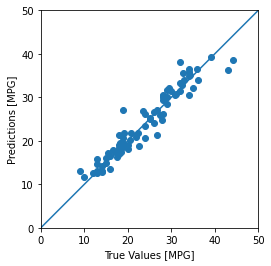

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

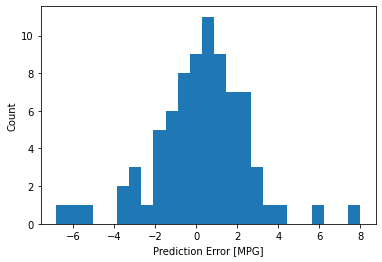

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

### 모델 저장

In [ ]:
dnn_model.save('./mlp-model')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


모델을 다시 로드해도 동일한 출력이 제공됩니다.

In [ ]:
reloaded = tf.keras.models.load_model('./mlp-model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_model,1.718921
reloaded,1.718921


In [ ]:
test_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,8,390.0,190,3850,8.5,70,0,0,1
25,8,360.0,215,4615,14.0,70,0,0,1
28,8,304.0,193,4732,18.5,70,0,0,1
31,4,113.0,95,2228,14.0,71,0,1,0
32,6,232.0,100,2634,13.0,71,0,0,1


In [ ]:
# 이렇게 추론할 수 있습니다.
inp = test_features.iloc[0]
print(reloaded(inp))

# 이렇게도 추론할 수 있습니다.
inp = np.array([8.0, 390.0, 190.0, 3850.0, 8.5, 70.0, 0.0, 0.0, 1.0])
print(reloaded(inp))

tf.Tensor([[15.938437]], shape=(1, 1), dtype=float32)
tf.Tensor([[15.938437]], shape=(1, 1), dtype=float32)
